In [89]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [90]:
df = pd.read_csv("dominigames_test.csv")
df.head(5)

,Transaction Time,Vendor SKU,Title,Item Name,Item Type,Units,Marketplace Currency,Sales Price (Marketplace Currency)
0,2020-01-31 23:57:21 PST,com.dominigames.mt9,Hidden Object - Mystery Tales: The Other Side,Hidden Object - Mystery Tales: The Other Side,Application,1,USD,0.00
1,2020-01-31 23:55:07 GMT,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,Application,1,GBP,0.00
2,2020-01-31 23:54:21 GMT,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,Application,1,GBP,0.00
3,2020-01-31 23:52:15 GMT,com.dominigames.sl2.unlock,Hidden Object - Spirit Legends: Solar Eclipse ...,Unlock,In-App,1,GBP,1.58
4,2020-01-31 23:51:01 PST,com.dominigames.dr8.unlock,Dark Romance: Winter Lily Collector's Edition,Unlock,In-App,1,USD,2.99


In [91]:
#приводим столбец Transaction Time к Datetime
timezone_replace = {'PST':'UTC-8', 'CET': 'UTC+1', 'EST':'UTC-5', 'JST':'UTC+9', 'AEDT':'UTC+11', 'PDT':'UTC-7', 'BST':'UTC+1', 'EDT':'UTC-4', 'GMT':'UTC'}
for key, value in timezone_replace.items():
    df['Transaction Time'] = df['Transaction Time'].str.replace(key, value, regex=False)
df['Transaction Time'] = pd.to_datetime(df['Transaction Time'],utc=True)

In [92]:
#Удаляем строки без значений. Их не много поэтому можем пожертвовать
df = df.dropna(axis=0)

In [93]:
#Подключаемся к API и получаем котировки
pairs = list(df['Marketplace Currency'].unique())
pairs = ','.join(pairs)

YOUR_APP_ID = '7a7eb9a1143e40a7b86a62539add63cf'
par = {'app_id':YOUR_APP_ID, 'base':'USD', 'symbols':pairs}
url_exchange = 'https://openexchangerates.org/api/latest.json'
rates = requests.get(url_exchange, params=par).json()['rates']

In [94]:
#подготавливаем данные для рассчета финальной таблицы
df['Sales Price (Marketplace Currency)'] = df['Sales Price (Marketplace Currency)'].apply(lambda x: abs(x))
df['Application'] = df['Item Type'].apply(lambda x:1 if x == 'Application' else 0)
df['In-App'] = df['Item Type'].apply(lambda x:1 if x == 'In-App' else 0)
df['USD Sum'] = df.apply(lambda row: row['Sales Price (Marketplace Currency)'] / rates[row['Marketplace Currency']] * row['Units'], axis=1)
df['USD Sum'] = df['USD Sum'].round(2)
df.head(5)

,Transaction Time,Vendor SKU,Title,Item Name,Item Type,Units,Marketplace Currency,Sales Price (Marketplace Currency),Application,In-App,USD Sum
0,2020-01-31 15:57:21+00:00,com.dominigames.mt9,Hidden Object - Mystery Tales: The Other Side,Hidden Object - Mystery Tales: The Other Side,Application,1,USD,0.00,1,0,0.00
1,2020-01-31 23:55:07+00:00,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,Application,1,GBP,0.00,1,0,0.00
2,2020-01-31 23:54:21+00:00,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,Application,1,GBP,0.00,1,0,0.00
3,2020-01-31 23:52:15+00:00,com.dominigames.sl2.unlock,Hidden Object - Spirit Legends: Solar Eclipse ...,Unlock,In-App,1,GBP,1.58,0,1,1.94
4,2020-01-31 15:51:01+00:00,com.dominigames.dr8.unlock,Dark Romance: Winter Lily Collector's Edition,Unlock,In-App,1,USD,2.99,0,1,2.99


In [95]:
#фильтруем дату для вывода отчета
start_date = '2020-01-15'
end_date = '2020-02-16'
df_to_report = df[(df['Transaction Time'] > start_date) & (df['Transaction Time'] < end_date)]

In [96]:
#вывод финального отчета
df_to_report = df_to_report.groupby('Title')[['Application', 'In-App', 'USD Sum']].agg(sum).sort_values(['USD Sum'])
df_to_report

,Application,In-App,USD Sum
Title,,,
Domini Games App,251,0,0.00
Hidden Object - Mystery Tales: The House of Others Collector's Edition,0,3,13.11
Spirit Legends: The Forest Wraith Collector's Edition,60,21,66.61
Labyrinths Of The World: Stonehenge Legend,117,37,97.33
Dark Romance: Kingdom Of Death Collector's Edition,81,35,99.59
Halloween Chronicles: Monsters Among Us Collector's Edition,210,43,112.28
Hidden Objects - Secret City: The Sunken Kingdom Collector's Edition,168,44,135.74
Enchanted Kingdom: Fog of Rivershire,287,48,137.93
Mystery Tales: The Hangman Returns Collector's Edition,186,43,141.29


## Advanced Analitics

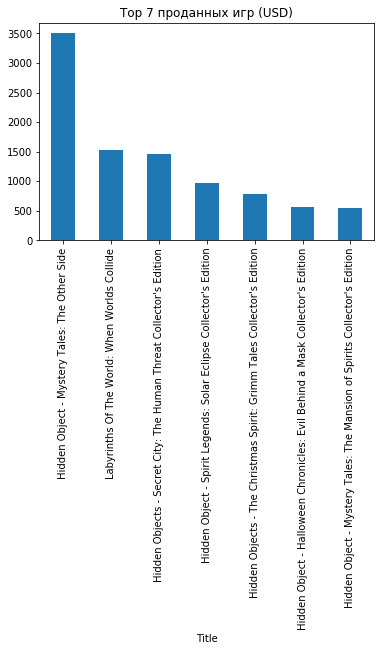

In [97]:
df_g = df_to_report['USD Sum'].sort_values(ascending=False).head(7)
df_g.plot(kind='bar', title="Top 7 проданных игр (USD)")
plt.show()

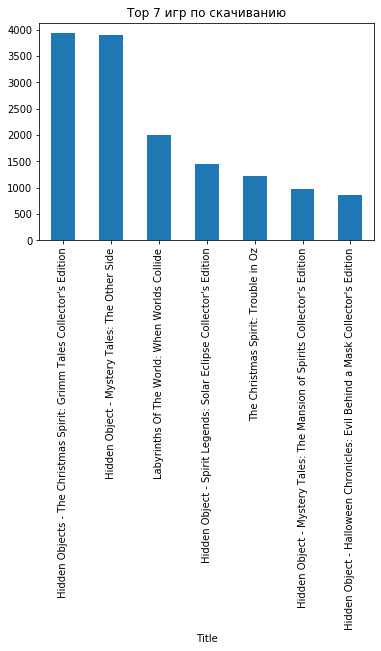

In [98]:
df_g = df_to_report['Application'].sort_values(ascending=False).head(7)
df_g.plot(kind='bar', title="Top 7 игр по скачиванию")
plt.show()

In [99]:
#нормализация для вывода значений в процентах
norm_df = df_to_report[:]
norm_df['USD Sum'] = df_to_report['USD Sum'] / df_to_report['USD Sum'].sum()
norm_df = norm_df.reset_index()

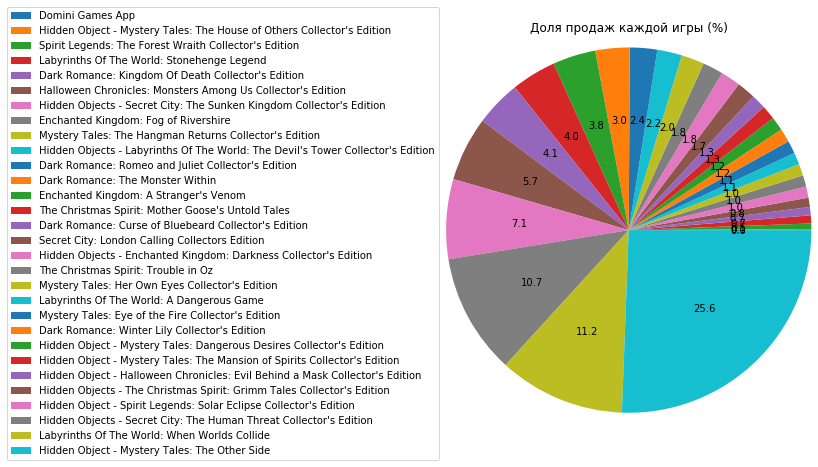

In [100]:
plt.title('Доля продаж каждой игры (%)', pad=90)
plt.pie(norm_df['USD Sum'],autopct='%.1f', radius = 2.1)
plt.legend(bbox_to_anchor = (0, 0.35, -0.35, 1.2), labels = norm_df['Title'],loc = 'upper right')